 1. En deskriptiv sammanfattning över databasen
 

In [15]:
import matplotlib 
matplotlib.use("TkAgg")
%matplotlib inline
import pandas as pd
from sqlalchemy import create_engine
import pyodbc
import matplotlib.pyplot as plt
from IPython.display import display

In [16]:
# Define your connection parameters
server_name = 'IZAC'  # Replace with your server name
database_name = 'AdventureWorks2022'  # Replace with your database name
username = ''  # Replace with your username (if applicable)
password = ''  # Replace with your password (if applicable)

# Create the SQLAlchemy engine
if username and password:
    engine = create_engine(f'mssql+pyodbc://{username}:{password}@{server_name}/{database_name}?driver=SQL Server')
else:
    engine = create_engine(f'mssql+pyodbc://{server_name}/{database_name}?driver=SQL Server&trusted_connection=yes')

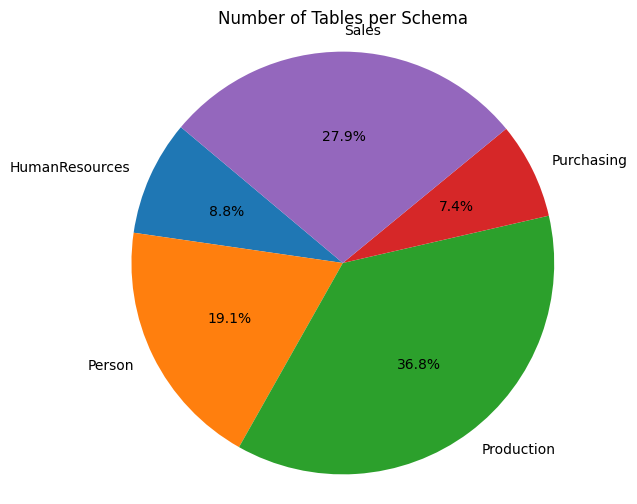

In [20]:
query = """
SELECT TABLE_SCHEMA, COUNT(*) AS TableCount
FROM INFORMATION_SCHEMA.TABLES
WHERE TABLE_TYPE = 'BASE TABLE'
AND TABLE_SCHEMA != 'dbo' 
GROUP BY TABLE_SCHEMA
ORDER BY TABLE_SCHEMA ASC;
"""

# Execute the query and store the result in a DataFrame
df = pd.read_sql(query, engine)

# Visualize the data in a pie chart
plt.figure(figsize=(6, 6))
plt.pie(df['TableCount'], labels=df['TABLE_SCHEMA'], autopct='%1.1f%%', startangle=140)
plt.title('Number of Tables per Schema')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

,SalesReason,Occurrences,TotalRevenueUSD
0,Price,20580,4779212
1,On Promotion,3416,3227436
2,Manufacturer,972,3219460
3,Quality,835,2987855
4,Review,797,879312
5,Other,1624,113607
6,Television Advertisement,344,13314


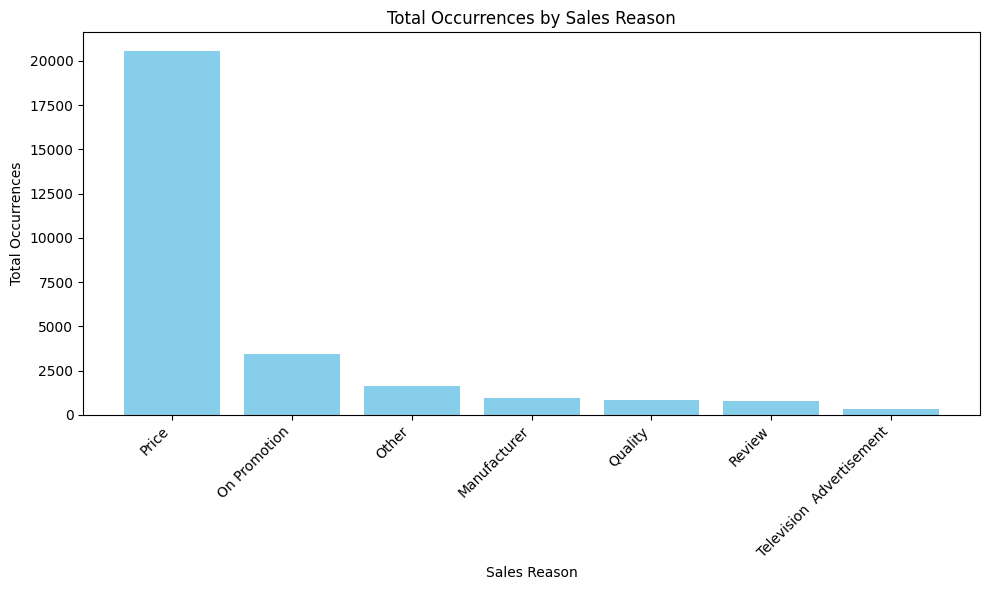

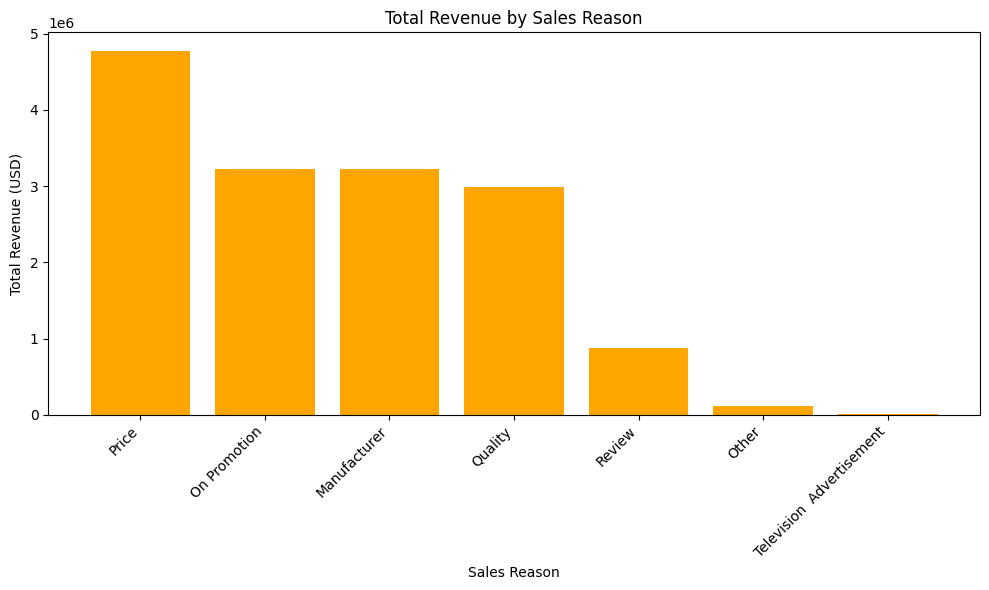

In [21]:
query = """
    SELECT sr.Name AS SalesReason,
       COUNT(sohsr.SalesOrderID) AS Occurrences,
       SUM(
           CASE 
               WHEN cr.FromCurrencyCode = 'USD' THEN sod.LineTotal
               ELSE sod.LineTotal * cr.EndOfDayRate
           END
       ) AS TotalRevenueUSD
    FROM Sales.SalesReason sr
    INNER JOIN Sales.SalesOrderHeaderSalesReason sohsr
        ON sr.SalesReasonID = sohsr.SalesReasonID
    INNER JOIN Sales.SalesOrderHeader soh
        ON sohsr.SalesOrderID = soh.SalesOrderID
    INNER JOIN Sales.CurrencyRate cr
        ON soh.CurrencyRateID = cr.CurrencyRateID
    INNER JOIN Sales.SalesOrderDetail sod
        ON soh.SalesOrderID = sod.SalesOrderID
    GROUP BY sr.Name
    ORDER BY TotalRevenueUSD DESC;
  """


# Load query results into a DataFrame
df = pd.read_sql(query, engine)
df["TotalRevenueUSD"] = df["TotalRevenueUSD"].apply(lambda x: int(x + 0.5))
display(df)

    

    
#Sort the DataFrame by 'Occurrences' for the occurrences plot
df_sorted_occurrences = df.sort_values(by="Occurrences", ascending=False)
    
#Plot Total Occurrences by Sales Reason
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.bar(df_sorted_occurrences["SalesReason"], df_sorted_occurrences["Occurrences"], color="skyblue")
ax2.set_xlabel("Sales Reason")
ax2.set_ylabel("Total Occurrences")
ax2.set_title("Total Occurrences by Sales Reason")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



#Sort the DataFrame by 'TotalRevenueUSD' for the revenue plot
df_sorted_revenue = df.sort_values(by="TotalRevenueUSD", ascending=False)
    
#Plot Total Revenue by Sales Reason
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(df_sorted_revenue["SalesReason"], df_sorted_revenue["TotalRevenueUSD"], color="orange")
ax1.set_xlabel("Sales Reason")
ax1.set_ylabel("Total Revenue (USD)")
ax1.set_title("Total Revenue by Sales Reason")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

2. Statistisk analys

In [19]:
import numpy as np
from scipy import stats

mean_revenue = df['TotalRevenueUSD'].mean()
std_revenue = df['TotalRevenueUSD'].std(ddof=1) 

# Provsstorlek
n = len(df['TotalRevenueUSD'])

# Standardfel
se = std_revenue / np.sqrt(n)

# Kritiskt värde för 95% konfidens
alpha = 0.05
t_critical = stats.t.ppf(1 - alpha/2, df=n-1)

# Felmarginal
margin_error = t_critical * se


ci_lower = mean_revenue - margin_error
ci_upper = mean_revenue + margin_error


print(f"95% konfidensintervall för medelvärdet av Total Revenue (USD): ({ci_lower:.2f}, {ci_upper:.2f})")


95% konfidensintervall för medelvärdet av Total Revenue (USD): (475590.71, 3873036.72)


3. Excutive summery